In [1]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
sys.path.append('../src')

In [5]:
from models import train_model
from features import build_features
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Transforming the data into usable shape for the later stages. Saving the transformer to be used in the predict model later. 

In [ ]:
data = pd.read_csv("../data/raw/data.csv", encoding='latin-1')
clf = FeatureGenerator()
clf.fit(data)
XX = clf.transform(data)
# Saving the data
XX.to_csv('../data/processed/data.csv', encoding='latin-1')
# Saving the model
joblib.dump(clf, '../models/transformer.pkl')


### Loading the transformed data again 

In [4]:
data = pd.read_csv("../data/processed/data.csv",index_col=0,encoding='latin-1')

In [5]:
pred = list(data.columns)
pred.remove("hammer_price")

lbl = data["hammer_price"]
data = data[pred]

In [6]:
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor
                              )
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection

from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingCVRegressor

def rmse(ground_truth, predictions):
    mse = metrics.mean_squared_error(ground_truth,predictions)
    return np.sqrt(mse)


In [7]:
train,test,y_train,y_test = train_model.model_selection.train_test_split(data,lbl,train_size=0.7,test_size=0.3)

### FIND THE BEST Regressors for Stacking method. 

In [10]:
param_grid = {
    'n_estimators':[100,50,500,1000],
    'learning_rate':[0.1,0.2,0.3,0.5,0.7],
    'loss':['linear','square','exponential'],
    'base_estimator__splitter' : ['best','random'],
    'base_estimator__max_features' : [3,5,'sqrt',0.3],
}
clf = AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_features=3))
res = train_model.benchmark(clf,train.values,y_train.values,test.values,y_test.values,param_grid,np.array(train.columns),n_iter=10,cv_fold=3)

________________________________________________________________________________
Training: 
AdaBoostRegressor
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=500, loss=square, learning_rate=0.5, base_estimator__splitter=best, base_estimator__max_features=0.3 
[CV]  n_estimators=500, loss=square, learning_rate=0.5, base_estimator__splitter=best, base_estimator__max_features=0.3, total=  17.6s
[CV] n_estimators=500, loss=square, learning_rate=0.5, base_estimator__splitter=best, base_estimator__max_features=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s


[CV]  n_estimators=500, loss=square, learning_rate=0.5, base_estimator__splitter=best, base_estimator__max_features=0.3, total=  16.3s
[CV] n_estimators=500, loss=square, learning_rate=0.5, base_estimator__splitter=best, base_estimator__max_features=0.3 
[CV]  n_estimators=500, loss=square, learning_rate=0.5, base_estimator__splitter=best, base_estimator__max_features=0.3, total=  26.3s
[CV] n_estimators=50, loss=square, learning_rate=0.3, base_estimator__splitter=best, base_estimator__max_features=0.3 
[CV]  n_estimators=50, loss=square, learning_rate=0.3, base_estimator__splitter=best, base_estimator__max_features=0.3, total=   7.1s
[CV] n_estimators=50, loss=square, learning_rate=0.3, base_estimator__splitter=best, base_estimator__max_features=0.3 
[CV]  n_estimators=50, loss=square, learning_rate=0.3, base_estimator__splitter=best, base_estimator__max_features=0.3, total=   6.7s
[CV] n_estimators=50, loss=square, learning_rate=0.3, base_estimator__splitter=best, base_estimator__max

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.2min finished


train time: 863.311s
r2: 0.42976572352
Mean Absolute Error : 60538.8623405
Mean Sq Error : 224474346043.0
test time:  0.633s



In [19]:
res[1].sort_values('mean_test_rmse',ascending=False).iloc[[0,1,2,3],"params"].values

array([ {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.3, 'base_estimator__splitter': 'best', 'base_estimator__max_features': 0.3},
       {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.5, 'base_estimator__splitter': 'random', 'base_estimator__max_features': 3},
       {'n_estimators': 500, 'loss': 'exponential', 'learning_rate': 0.1, 'base_estimator__splitter': 'random', 'base_estimator__max_features': 3}], dtype=object)

### Finding the best set of params for StackingCV with 4 additional regressors and Random Forest as Meta regressor.

In [23]:
rf = RandomForestRegressor(n_jobs=-1,verbose=1)
stack = StackingCVRegressor(
    regressors=(
        AdaBoostRegressor(n_estimators=50,loss='square',learning_rate=0.3,base_estimator=tree.DecisionTreeRegressor(max_features=0.3,splitter='best')),
        AdaBoostRegressor(n_estimators=50,loss='square',learning_rate=0.3,base_estimator=tree.DecisionTreeRegressor(max_features=0.5,splitter='best')),
        AdaBoostRegressor(n_estimators=50,loss='square',learning_rate=0.5,base_estimator=tree.DecisionTreeRegressor(max_features=3)),
        AdaBoostRegressor(n_estimators=500,loss='exponential',learning_rate=0.1,base_estimator=tree.DecisionTreeRegressor(max_features=3,splitter='random')),
    ),meta_regressor=rf,use_features_in_secondary=True)

param_grid={            
        'meta-randomforestregressor__n_estimators': [10,50,100,500],
        'meta-randomforestregressor__max_features' : [3,5,0.3,0.5,0.7]
    }

res = train_model.benchmark(stack,train.values,y_train.values,test.values,y_test.values,param_grid,np.array(train.columns),n_iter=10,cv_fold=3)


________________________________________________________________________________
Training: 
StackingCVRegressor
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.5, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.5, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.5, total= 3.2min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.3, total= 3.1min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.3, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.3, total= 3.5min
[CV] meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=3, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=3, total= 3.0min
[CV] meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  meta-randomforestregressor__n_estimators=50, meta-randomforestregressor__max_features=3, total= 3.2min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=3, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=3, total= 3.0min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=3, total= 3.2min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=5, total= 3.2min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=5, total= 3.2min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=5, total= 3.5min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=3, total= 2.7min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=3, total= 2.6min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=3 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=3, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.3, total= 2.8min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.3, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.3, total= 3.1min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.5, total= 2.8min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.5, total= 2.6min
[CV] meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV]  meta-randomforestregressor__n_estimators=10, meta-randomforestregressor__max_features=0.5, total= 2.9min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.5, total= 3.0min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.5, total= 3.1min
[CV] meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.5 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  

[CV]  meta-randomforestregressor__n_estimators=500, meta-randomforestregressor__max_features=0.5, total= 3.4min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.3, total= 2.7min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.3, total= 2.7min
[CV] meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.3 


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  meta-randomforestregressor__n_estimators=100, meta-randomforestregressor__max_features=0.3, total= 3.0min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 96.7min finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


train time: 6023.719s
r2: 0.498829371067
Mean Absolute Error : 77341.2910125
Mean Sq Error : 197287244604.0
test time:  4.104s



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


### Running StackingCVRegressor with set parameters and saving it later.

In [9]:
rf_final = RandomForestRegressor(n_jobs=-1,verbose=1,max_features=3,n_estimators=50)
stack_final = StackingCVRegressor(
    regressors=(
        AdaBoostRegressor(n_estimators=50,loss='square',learning_rate=0.3,base_estimator=tree.DecisionTreeRegressor(max_features=0.3,splitter='best')),
        AdaBoostRegressor(n_estimators=50,loss='square',learning_rate=0.3,base_estimator=tree.DecisionTreeRegressor(max_features=0.5,splitter='best')),
        AdaBoostRegressor(n_estimators=50,loss='square',learning_rate=0.5,base_estimator=tree.DecisionTreeRegressor(max_features=3)),
        AdaBoostRegressor(n_estimators=500,loss='exponential',learning_rate=0.1,base_estimator=tree.DecisionTreeRegressor(max_features=3,splitter='random')),
    ),meta_regressor=rf_final,use_features_in_secondary=True,store_train_meta_features=False)
stack_final.fit(data.values,lbl.values)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


StackingCVRegressor(cv=5,
          meta_regressor=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False),
          regressors=(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=0.3,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
     ...om'),
         learning_rate=0.1, loss='exponential', n_estimators=500,
         random_state=None)),
          shuffle=True, store_train_meta_features=True,
          use_features_in_secondary=True)

In [10]:
rmse(lbl.values,stack_final.predict(data.values))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


561129.23875279876

In [32]:
from sklearn.externals import joblib

In [34]:
joblib.dump(stack_final,'../models/stacked_regressor.pkl')

['../models/stacked_regressor.pkl']

# Answering the questions

## Q1 : Which features are most important for your model? Are there any that surprised to you? 

Since I'm using a Stacking method, It makes sense that Level-1 features are more important to my model and this is the intented behaviour. 
But as a sidenote, It's very interesting that the features related to the size of the articles (*measurement_height,measurement_width,surface,aspect_ratio*) are also in the top-10 features. 
**This signals the fact that more features like those will be helpful**

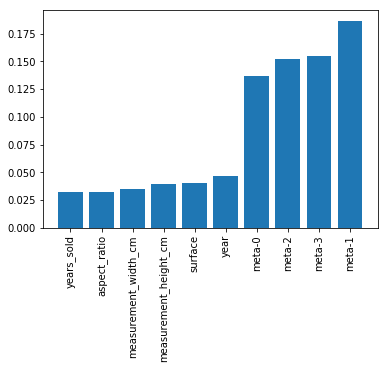

In [28]:
%matplotlib inline
cols= np.hstack((list(train.columns),["meta-"+str(i) for i in range(4)]))
importance = stack_final.meta_regr_.feature_importances_
x = np.argsort(importance)[-10:]
plt.bar(range(0,len(x)),importance[x])
plt.xticks(range(0,len(x)),tuple(cols[x]),rotation='vertical')
plt.show()

## Q2 : What additional data or features do you think would help increase performance?

This is an interesting question since gathering more features usually means significantly higher effort. But since most of the top-10 features (*As described in Q1*) are related to the phsyical appearance of the Art piece, I think, **Convolutional features extracted from the image of the Art piece** would be really helpful. Another interesting set of features would be: 
1. physical state, 
2. rarity
3. provenance 
4. historical importance 
5. subject matter
6. Is artist a celebrity
7. Significance of the artist

## Q3 : How would you predict the price of a work if you were only given the artist name, type of work, and size?

Based on my findings, *the size of work has an immense predictive power*. This means, I would first create several engineered features like, **aspect_ratio, surface** from the size of the work. Since the artist name is also given, I would divide data into several pieces based on the artist name. For each artist, I would create a Regression model with adequate predictive power. Then I would stack all these regressors and use a Meta-regressor to predict the final value.  

## Q4 : What happened to works by Sol Lewitt before, during and after the 2007-2008 financial crisis. How quickly did prices return to pre-2008 levels?

In [11]:
sol_data = pd.read_csv("../data/raw/data.csv",encoding='latin-1')
sol_data = sol_data.loc[sol_data.artist_name == "Sol LeWitt"]
sol_data.loc[:,"auction_date"] = pd.to_datetime(sol_data.auction_date)
sol_data = sol_data.loc[:,["auction_date","hammer_price"]]
sol_data = sol_data.sort_values("auction_date")

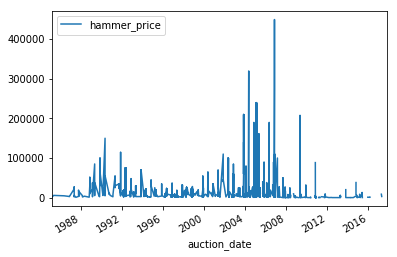

In [12]:
sol_data.plot(x= "auction_date",y="hammer_price")

By looking at the graph above, we can see several interesting patterns.
1. There is a discernible interest in the work of *Sol Lewitt* from 1989 to 1996 with **558** pieces sold with average hammer_price of 17584 USD. 
2. Between the years 1996 to 2002, there is a noticable drop in price of pieces albeit having almost the same number of pieces sold.*(558 to 523)*. 
3. From the year 2002 to just before the financial crisis, there is a boom in the price of his work with almost **700** pieces sold average around **24,000 USD**.
4. During the crisis, we see an expected decline in both the number of pieces sold and the price of them. 
5. Interesting enough, after the market crash of 2007-2008, these prices have not returned to their pre-crisis values. With almost 9 years from the crisis, only 101 pieces have been auctioned with the maximum hammer price equal to half of the same preiod before the crisis.

In [26]:
sol_data.loc[np.logical_and(sol_data.auction_date > '1989-01-01',sol_data.auction_date < '1996-01-01')].describe()

,hammer_price
count,558.000000
mean,17584.318996
std,21234.837458
min,1000.000000
25%,4000.000000
50%,8500.000000
75%,23000.000000
max,150000.000000


In [27]:
sol_data.loc[np.logical_and(sol_data.auction_date > '1996-01-01',sol_data.auction_date < '2002-01-01')].describe()

,hammer_price
count,523.000000
mean,10391.261950
std,14013.411007
min,600.000000
25%,2200.000000
50%,5500.000000
75%,13000.000000
max,110000.000000


In [28]:
sol_data.loc[np.logical_and(sol_data.auction_date > '2002-01-01',sol_data.auction_date < '2007-01-01')].describe()

,hammer_price
count,683.000000
mean,23041.329429
std,49575.869901
min,430.000000
25%,2975.000000
50%,5500.000000
75%,15000.000000
max,450000.000000


In [29]:
sol_data.loc[np.logical_and(sol_data.auction_date > '2007-01-01',sol_data.auction_date < '2009-01-01')].describe()

,hammer_price
count,103.000000
mean,4729.669903
std,12186.053252
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,5150.000000
max,100000.000000


In [30]:
sol_data.loc[np.logical_and(sol_data.auction_date > '2009-01-01',sol_data.auction_date < '2018-01-01')].describe()

,hammer_price
count,101.000000
mean,5619.277228
std,22815.876933
min,-1.000000
25%,-1.000000
50%,600.000000
75%,3000.000000
max,207917.000000
